# Projet Séries Chronologiques : Ventes d'une boutique

## Données 

 Ensemble de données de vente au détail d'un supermarché mondial pendant 4 ans. (Kaggle)

Importation des packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
import torch
from jyquickhelper import add_notebook_menu
#add_notebook_menu()
#plt.style.use('')
plt.rcParams['figure.figsize'] = 18,8
pd.set_option('display.max_columns', None)


from sklearn.metrics import mean_squared_error


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm


In [5]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

Récupérons les données

In [6]:
df = pd.read_csv('data/data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

On souhaite représenter seulement les ventes au fil du temps.

In [7]:

df = df[['Order Date','Sales']]
df.rename(columns={'Order Date' : 'Date'},inplace = True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df.Date,inplace = True)
df.drop('Date',axis=1,inplace = True)
display(df)



,Sales
Date,
2017-08-11,261.9600
2017-08-11,731.9400
2017-12-06,14.6200
2016-11-10,957.5775
2016-11-10,22.3680
...,...
2017-05-21,3.7980
2016-12-01,10.3680
2016-12-01,235.1880


On retrouve 9800 observations.

Vérifions si nous avons des données manquantes dans notre série temporelle, si c'est le cas notre série temporelle ne fonctionnera pas.

In [8]:
df.isna().sum()

Sales    0
dtype: int64

Il n'y a pas de données manquantes.

In [9]:
df.describe()


,Sales
count,9800.000000
mean,230.769059
std,626.651875
min,0.444000
25%,17.248000
50%,54.490000
75%,210.605000
max,22638.480000


On constate que les ventes possèdent des valeurs aberrantes.

In [10]:
df.describe()


,Sales
count,9800.000000
mean,230.769059
std,626.651875
min,0.444000
25%,17.248000
50%,54.490000
75%,210.605000
max,22638.480000


In [11]:
data=df.copy()
data.sort_values(by=['Date'])
data.shape

(9800, 1)

## Analyse descriptive

### Par jour

In [12]:

df_day = df.resample('D').mean()
display(df_day)

,Sales
Date,
2015-01-02,468.900000
2015-01-03,220.315100
2015-01-04,29.972000
2015-01-05,NaN
2015-01-06,471.683636
...,...
2018-12-26,203.648500
2018-12-27,88.818000
2018-12-28,87.228989


In [13]:
df_day.describe()


,Sales
count,1230.000000
mean,226.732806
std,276.130382
min,2.025000
25%,88.274583
50%,158.369708
75%,266.602519
max,4297.644000


On remplace les Na par 0

In [14]:

df_day = df_day.fillna(0)
display(df_day)

,Sales
Date,
2015-01-02,468.900000
2015-01-03,220.315100
2015-01-04,29.972000
2015-01-05,0.000000
2015-01-06,471.683636
...,...
2018-12-26,203.648500
2018-12-27,88.818000
2018-12-28,87.228989


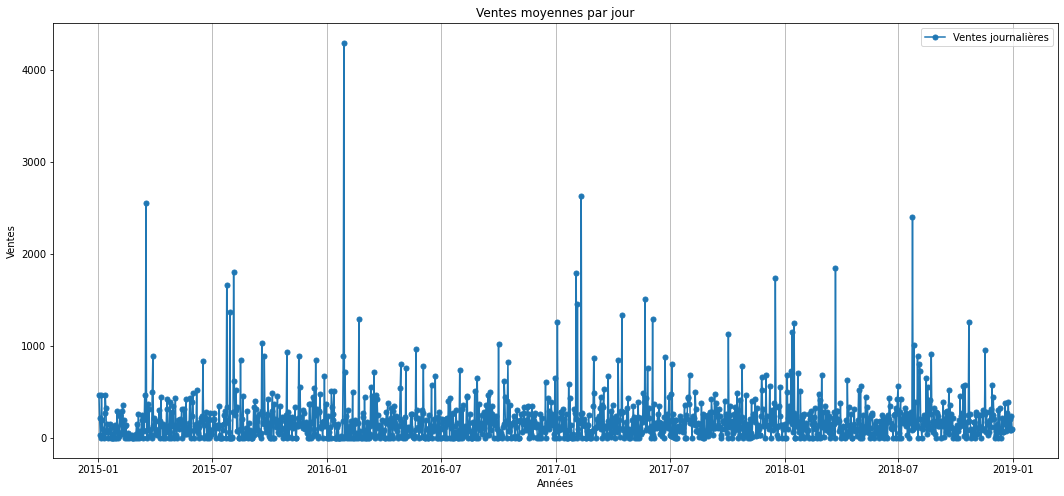

In [15]:
y = df_day['Sales']
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(y,marker = 'o',markersize='5',linestyle='-',label = 'Ventes journalières')
ax.grid(axis='x')
ax.set_xlabel('Années')
ax.set_ylabel('Ventes')
ax.set_title('Ventes moyennes par jour')

ax.legend();

On constate des piques
Faisons un test de points abhérants

In [16]:
from kats.detectors.seasonality import FFTDetector
from kats.detectors.outlier import OutlierDetector
from kats.consts import TimeSeriesData


In [17]:
# Transdormation en format timesseries pour la manipulation ave la lib Kats
df_day['time']=df_day.index
df_day_ts= TimeSeriesData(df_day)
display(df_day_ts)

,time,Sales
0,2015-01-02,468.900000
1,2015-01-03,220.315100
2,2015-01-04,29.972000
3,2015-01-05,0.000000
4,2015-01-06,471.683636
...,...,...
1454,2018-12-26,203.648500
1455,2018-12-27,88.818000
1456,2018-12-28,87.228989
1457,2018-12-29,242.961167


In [18]:
outlier_detector = OutlierDetector(df_day_ts, "additive")

outlier_detector.detector()
outliers = outlier_detector.outliers
outliers[0]

[Timestamp('2015-03-18 00:00:00'),
 Timestamp('2015-03-29 00:00:00'),
 Timestamp('2015-07-25 00:00:00'),
 Timestamp('2015-07-30 00:00:00'),
 Timestamp('2015-08-05 00:00:00'),
 Timestamp('2015-08-16 00:00:00'),
 Timestamp('2015-09-19 00:00:00'),
 Timestamp('2015-09-23 00:00:00'),
 Timestamp('2015-10-29 00:00:00'),
 Timestamp('2016-01-25 00:00:00'),
 Timestamp('2016-01-28 00:00:00'),
 Timestamp('2016-01-29 00:00:00'),
 Timestamp('2016-01-31 00:00:00'),
 Timestamp('2016-02-21 00:00:00'),
 Timestamp('2016-05-22 00:00:00'),
 Timestamp('2016-10-01 00:00:00'),
 Timestamp('2017-01-03 00:00:00'),
 Timestamp('2017-02-02 00:00:00'),
 Timestamp('2017-02-04 00:00:00'),
 Timestamp('2017-02-10 00:00:00'),
 Timestamp('2017-04-10 00:00:00'),
 Timestamp('2017-04-16 00:00:00'),
 Timestamp('2017-05-23 00:00:00'),
 Timestamp('2017-06-04 00:00:00'),
 Timestamp('2017-06-24 00:00:00'),
 Timestamp('2017-10-03 00:00:00'),
 Timestamp('2017-12-17 00:00:00'),
 Timestamp('2018-01-16 00:00:00'),
 Timestamp('2018-03-

On supprime les points abhérants

In [19]:
df_day_ts_outliers_interpolated = outlier_detector.remover(interpolate=True)
df_day_interpolated =df_day_ts_outliers_interpolated.to_dataframe()
df_day_interpolated.rename(columns={"y_0":'Sales'},inplace=True)
df_day_interpolated.set_index(['time'],inplace=True)
display(df_day_interpolated)

,Sales
time,
2015-01-02,468.900000
2015-01-03,220.315100
2015-01-04,29.972000
2015-01-05,0.000000
2015-01-06,471.683636
...,...
2018-12-26,203.648500
2018-12-27,88.818000
2018-12-28,87.228989


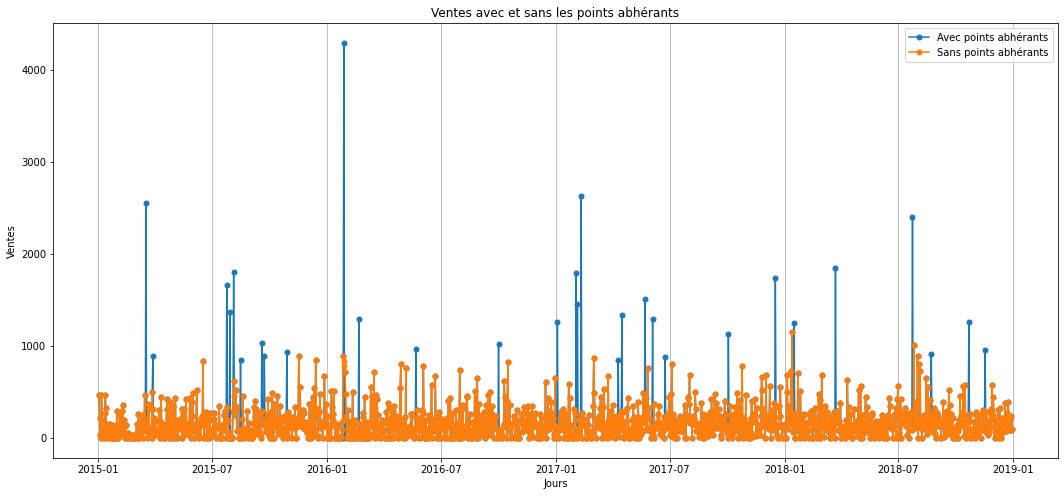

In [20]:
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df_day["Sales"],marker = 'o',markersize='5',linestyle='-',label = 'Avec points abhérants')
ax.plot(df_day_interpolated["Sales"],marker = 'o',markersize='5',linestyle='-',label = 'Sans points abhérants')

ax.set_xlabel('Jours')
ax.set_ylabel('Ventes')
ax.set_title('Ventes avec et sans les points abhérants')
ax.grid(axis='x')
ax.legend()

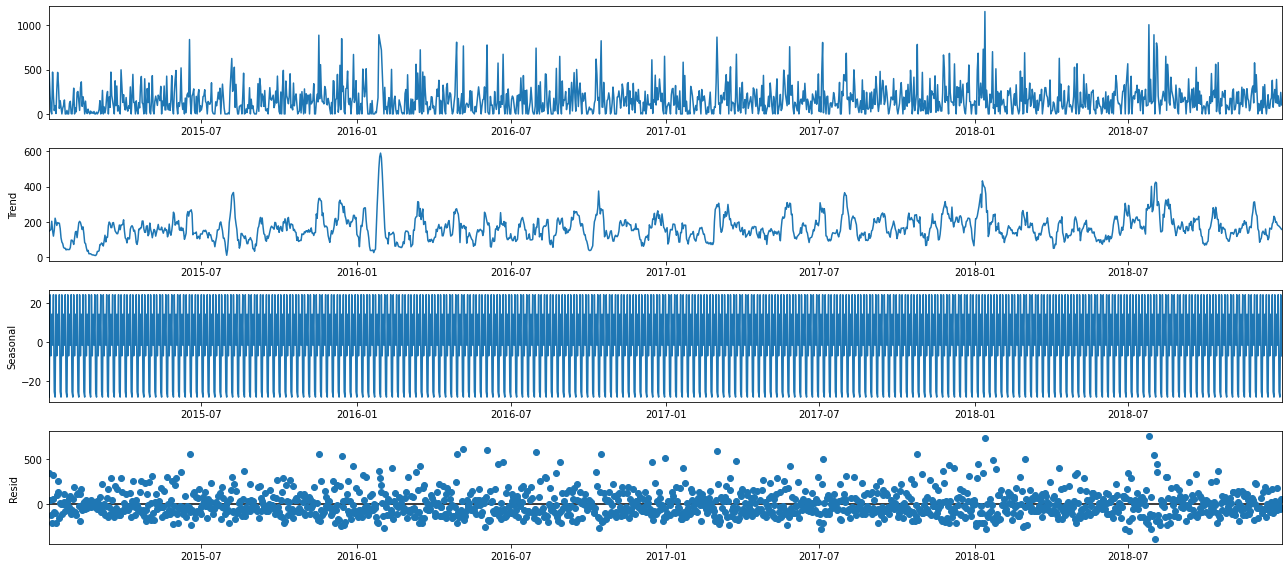

In [21]:
df_day_interpolated_dec=seasonal_decompose(df_day_interpolated,model='additive', extrapolate_trend='freq')
df_day_interpolated_dec.plot();

Ces données sont difficiles à exploiter, nous allons faire une moyenne par semaine


### Par Semaine

In [22]:
df_week = df_day_interpolated.resample('W').mean()
display(df_week)

,Sales
time,
2015-01-04,239.729033
2015-01-11,154.498506
2015-01-18,163.362348
2015-01-25,41.716424
2015-02-01,96.997714
...,...
2018-12-02,273.880471
2018-12-09,108.821959
2018-12-16,124.106523


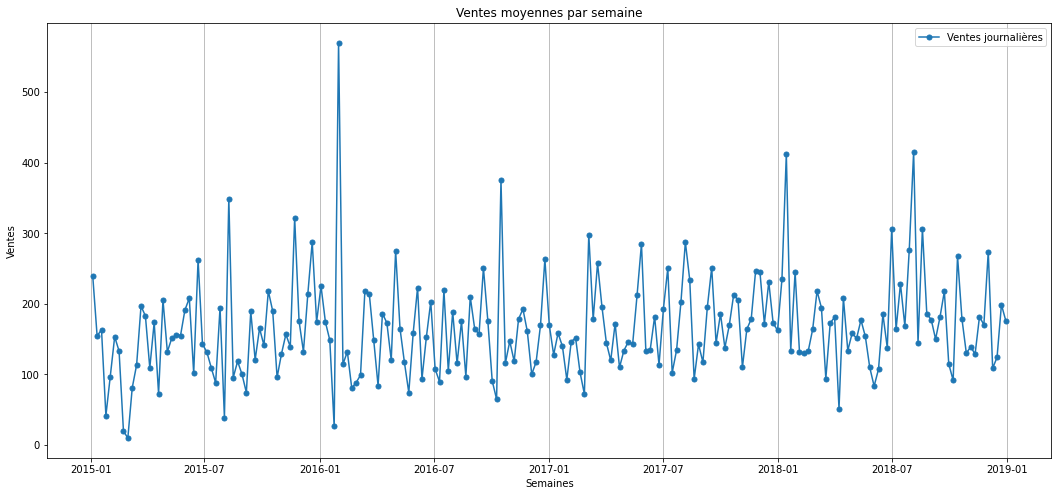

In [23]:
y = df_week['Sales']
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(y,marker = 'o',markersize='5',linestyle='-',label = 'Ventes journalières')
ax.set_xlabel('Semaines')
ax.set_ylabel('Ventes')
ax.set_title('Ventes moyennes par semaine')
ax.grid(axis='x')
ax.legend();

In [24]:
# Transdormation en format timesseries pour la manipulation ave la lib Kats
df_week['time']=df_week.index
df_week_ts= TimeSeriesData(df_week)
display(df_week_ts)

,time,Sales
0,2015-01-04,239.729033
1,2015-01-11,154.498506
2,2015-01-18,163.362348
3,2015-01-25,41.716424
4,2015-02-01,96.997714
...,...,...
204,2018-12-02,273.880471
205,2018-12-09,108.821959
206,2018-12-16,124.106523
207,2018-12-23,198.817483


#### Détection et élimination de points abhérants

In [25]:
outlier_detector = OutlierDetector(df_week_ts, "additive")

outlier_detector.detector()
outliers = outlier_detector.outliers
outliers[0]

[Timestamp('2016-01-31 00:00:00')]

In [26]:
df_week_ts_outliers_interpolated = outlier_detector.remover(interpolate=True)
df_week_interpolated =df_week_ts_outliers_interpolated.to_dataframe()
df_week_interpolated.rename(columns={"y_0":'Sales'},inplace=True)
df_week_interpolated.set_index(['time'],inplace=True)
display(df_week_interpolated)

,Sales
time,
2015-01-04,239.729033
2015-01-11,154.498506
2015-01-18,163.362348
2015-01-25,41.716424
2015-02-01,96.997714
...,...
2018-12-02,273.880471
2018-12-09,108.821959
2018-12-16,124.106523


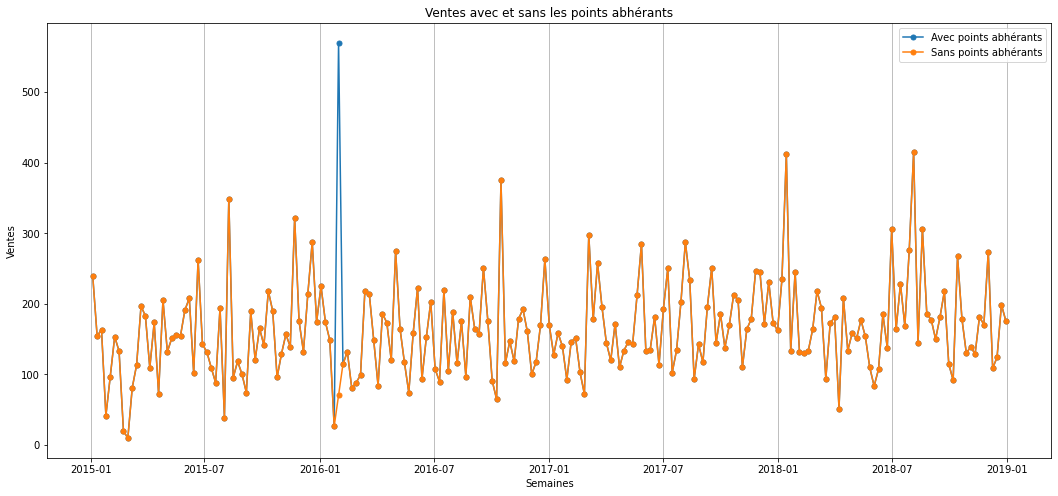

In [27]:
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df_week["Sales"],marker = 'o',markersize='5',linestyle='-',label = 'Avec points abhérants')
ax.plot(df_week_interpolated["Sales"],marker = 'o',markersize='5',linestyle='-',label = 'Sans points abhérants')

ax.set_xlabel('Semaines')
ax.set_ylabel('Ventes')
ax.set_title('Ventes avec et sans les points abhérants')
ax.grid(axis='x')
ax.legend()

#### Décomposition de notre série

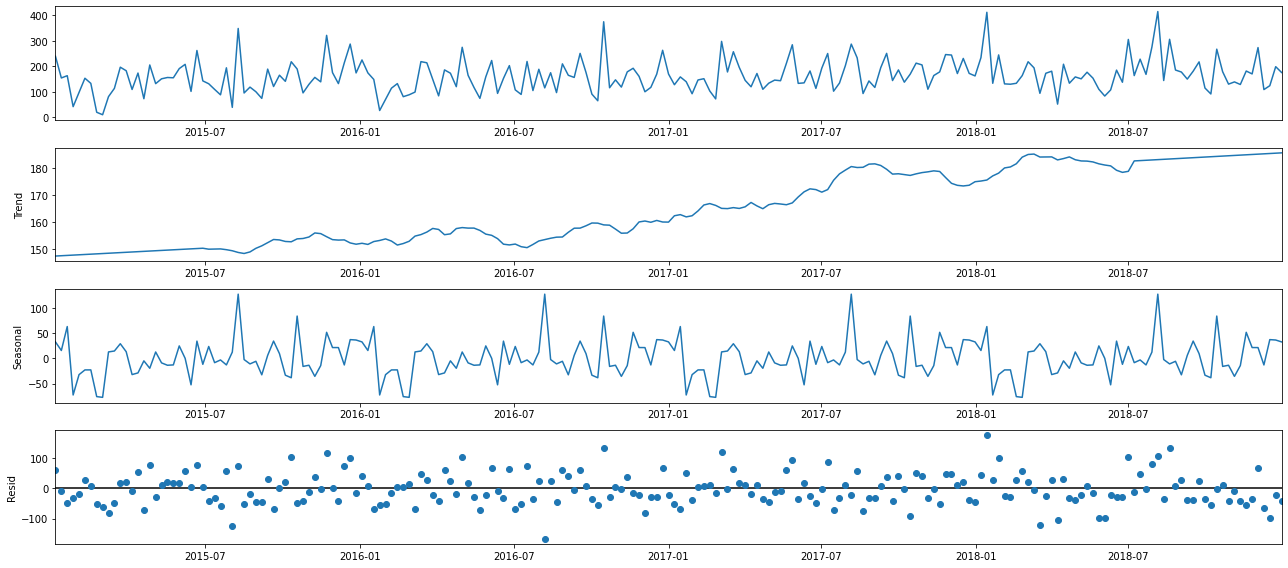

In [28]:
df_week_interpolated_dec=seasonal_decompose(df_week_interpolated,model='additive', extrapolate_trend='freq')
df_week_interpolated_dec.plot();

### Par mois

In [29]:
df_month_interpolated=df_week_interpolated.resample('M').mean()

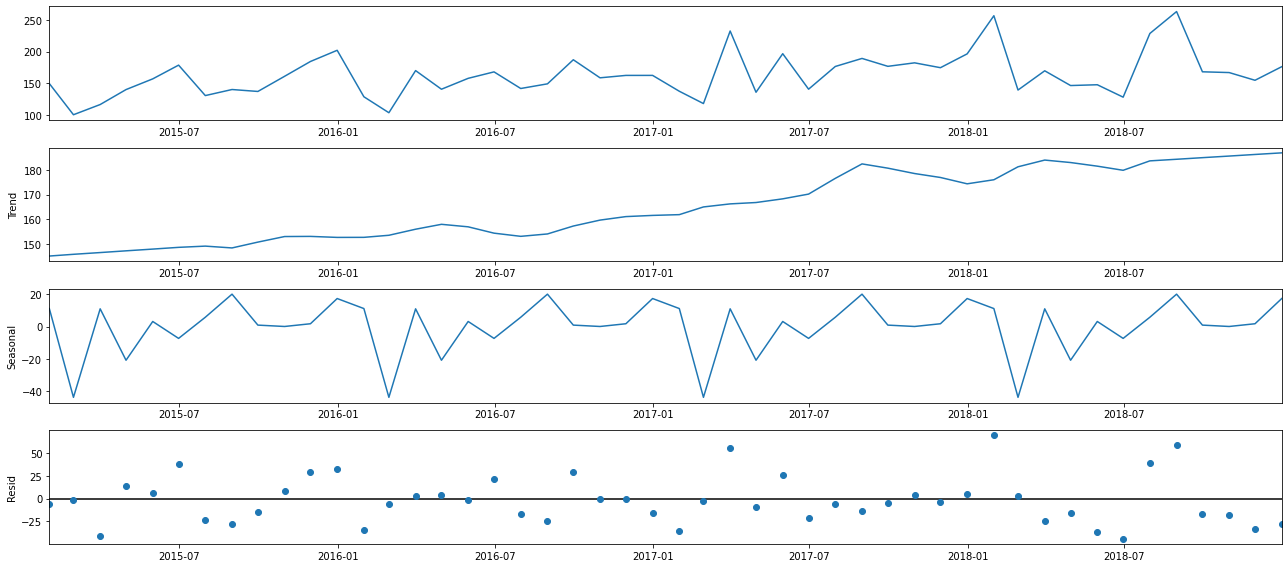

In [30]:
df_month_interpolated_dec=seasonal_decompose(df_month_interpolated,model='additive', extrapolate_trend='freq')
df_month_interpolated_dec.plot();

D'après cette sortie notre série à une tendance haussière.

On peut faire une hypothèse de saisonnalité. Nous allons vérifier cette hypothèse dans la suite par un test statistique.

Concernant la stationarité, nous allons la vérifier  par des deux méthodes: graphique et test.

#### Saisonnalité

Pour vérifier la saisonnalité de notre série, nous allons utiliser le test de saisonnalité implementé dans la librairie **kats**.

In [31]:
df_month_interpolated_ts= TimeSeriesData(df_month_interpolated.reset_index())
fft_detector = FFTDetector(df_month_interpolated_ts)
fft_detector.detector()

{'seasonality_presence': False, 'seasonalities': []}

D'après ce test, notre serie n'est pas saisonnière.
Nous allons tester la stationnarité.

#### Stationnarité

Nous allons vérifier la stationnarité de deux manières différentes:

    - Méthode graphique
    - Méthode par test statistique

In [32]:
sales_mean = df_month_interpolated.Sales.rolling(15).mean().dropna()
sales_std = df_month_interpolated.Sales.rolling(15).std().dropna()


Text(0.5, 1.0, 'Vérification de la stationnarité')

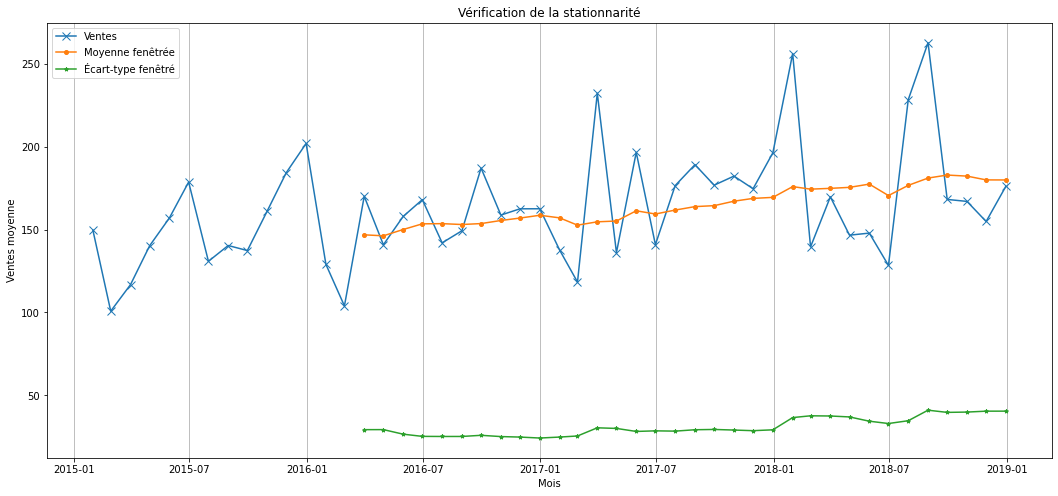

In [33]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df_month_interpolated.Sales,marker = 'x',markersize = 8 , label = 'Ventes')
ax.plot(sales_mean,marker= 'o', markersize = 4, label = 'Moyenne fenêtrée');
ax.plot(sales_std,marker = '*', markersize = 4, label = 'Écart-type fenêtré');
ax.legend()
ax.grid(axis='x')

plt.xlabel('Mois')
plt.ylabel('Ventes moyenne') 
plt.title('Vérification de la stationnarité')


En observant la moyenne et variance fenêtrée sur 20 élemnts, on se rend compte de la stabilité mais il est difficle de conclure concernant la stationnarité de notre série. Nous allons effectuer un test statistique.



**Test de Dickey-Fuller augmenté**

Le test augmenté de Dickey-Fuller est un test statistique qui est utilisé pour vérifier la racine unitaire d'une série temporelle.
Ce test retourne une p-value, une valeur de test statistique, et les valeurs critiques avec intervalles de confiance.
Selon la p-value obtenue, nous pourrons rejeter ou accepter l'hypothèse nulle.

$H_0$ : 'La série n'est pas stationnaire' $\\$
$H_1$ : 'La série est stationnaire'


In [34]:
def adfuller_test(ts):
	ts_test = adfuller(ts,autolag='AIC')
	print('Valeur de test statistique : {:.3f}'.format(ts_test[0]))
	print('P-value : {}'.format(ts_test[1]))
	for key, value in ts_test[4].items():
		print('\t%s: %.3f' % (key, value))
	print(f'Result: The series is {"not " if ts_test[1] > 0.05 else ""}stationary')


In [35]:
adfuller_test(df_month_interpolated)

Valeur de test statistique : -5.769
P-value : 5.449680063375146e-07
	1%: -3.578
	5%: -2.925
	10%: -2.601
Result: The series is stationary


D'après le résultat du test de Dickey Fuller augmenté, la série est stationnaire mais il ne sérait pas rigoureux de conclure sur ce test car ce test vérifie la racine unitaire de la série, qui est une forme particulière de non stationnarité. Nous allons effetuer un deuxième test: le de test de KPSS.

In [36]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


In [37]:
kpss_test(df_month_interpolated)

KPSS Statistic: 0.7294227537700431
p-value: 0.010870658748177902
num lags: 1
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


D'après le test de KPSS, nous avons une non stationnarité. Ce qui est en contradiction avec le résultat obtenu avec ADF. Nous allons dans ce as effectuer un test de ratio de variance.

In [38]:

def variance_ratio(ts, lag = 2):
    """
    Returns the variance ratio test result
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # Apply the formula to calculate the test
    n = len(ts)
    mu  = sum(ts[1:n]-ts[:n-1])/n;
    m=(n-lag+1)*(1-lag/n);
    b=sum(np.square(ts[1:n]-ts[:n-1]-mu))/(n-1)
    t=sum(np.square(ts[lag:n]-ts[:n-lag]-lag*mu))/m
    return t/(lag*b);

In [39]:
print(variance_ratio(df_month_interpolated,))

[0.57624192]


En considérant la tendance haussière, la moyenne et variance fénêtrée non linéaire, les résultats des tests statistiques, on décide de rejeter l'hypothèse de stionnarité.

Nous allons différencier notre série afin de la rendre stationnaire.

#### diférenciation

In [40]:
df_month_interpolated_diff = df_month_interpolated - df_month_interpolated.shift(1)
df_month_interpolated_diff.dropna(inplace=True)

Après différentiation d'ordre 1, nous allons refaire les tests de stationnarité.

In [41]:
adfuller_test(df_month_interpolated_diff)

Valeur de test statistique : -4.087
P-value : 0.0010185091408055932
	1%: -3.627
	5%: -2.946
	10%: -2.612
Result: The series is stationary


In [42]:
kpss_test(df_month_interpolated_diff)

KPSS Statistic: 0.15985959523528048
p-value: 0.1
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


Après différenciation d'ordre 1, les deux tests confirment que notre série est stationnaire.

### Prédiction

In [43]:
#Découpage App/Test
# découpage app/test
test_size = df_month_interpolated.shape[0]//4
train_size = df_month_interpolated.shape[0]-test_size

df_month_interpolated_train = df_month_interpolated.iloc[:train_size:]
df_month_interpolated_test = df_month_interpolated.iloc[train_size:]


#### Modèle naîf

In [44]:
df_month_interpolated_test['shifted_sales'] = df_month_interpolated_test.Sales.shift(1)
df_month_interpolated_test_naif=df_month_interpolated_test.dropna()

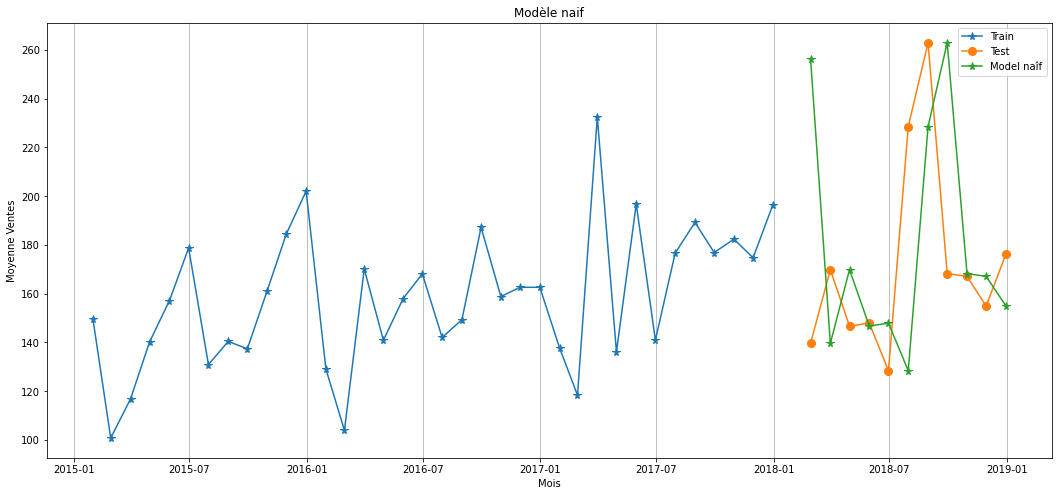

In [45]:

fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df_month_interpolated_train.Sales, marker ="*", markersize = 8 , label = 'Train')
ax.plot(df_month_interpolated_test_naif.Sales, marker = 'o', markersize = 8, label = 'Test')
ax.plot(df_month_interpolated_test_naif.shifted_sales, marker ="*", markersize = 8 , label = 'Model naîf')
ax.grid(axis='x')

plt.xlabel('Mois')
plt.ylabel('Moyenne Ventes')
plt.title('Modèle naif')
ax.legend()
plt.show()

In [46]:
df_month_interpolated = df_month_interpolated.dropna()
mse = mean_squared_error(df_month_interpolated_test_naif.Sales,df_month_interpolated_test_naif.shifted_sales)
rsme = np.sqrt(mse)

print(f"La racine de l'erreur quadratique moyenne du modèle naif est de : {rsme}")

La racine de l'erreur quadratique moyenne du modèle naif est de : 57.40095495140116


### Modèle Holt-winters

Testons maintenant le modèle additif de Holt-Winters pour prédire.
C'est un modèle de lissage exponentiel. Nous allons utiliser le lissage exponetielle double qui est une extension du lissage exponentiel qui ajoute explicitement la prise en charge des tendances dans les séries chronologiques univariées.
Nous avons fait ce choix car notre série chronologique a une tendance mais pas de saisonnalité (test négatif).

In [47]:
from statsmodels.tsa.api import  Holt

df_month_interpolated_test.drop('shifted_sales',axis=1,inplace=True)


In [48]:
model_holt_double = Holt(df_month_interpolated_train, exponential=True, initialization_method="estimated").fit(
    damping_trend=0.5
)

In [49]:
predictions_holt_double = model_holt_double.forecast(test_size)


In [50]:
model_holt_triple = ExponentialSmoothing(
    df_month_interpolated_train,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

In [51]:

predictions_holt_triple = model_holt_triple.forecast(test_size)


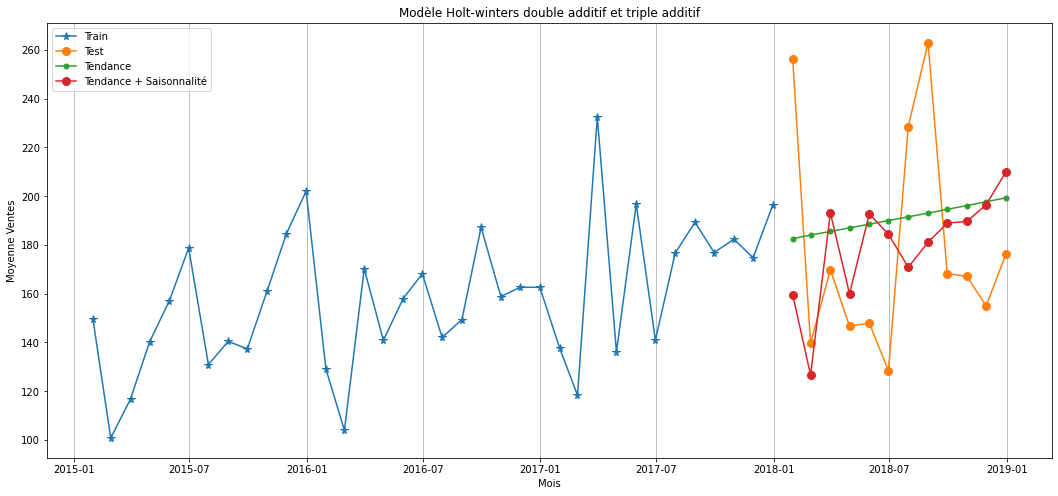

In [52]:

fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df_month_interpolated_train.Sales, marker ="*", markersize = 8 , label = 'Train' )
ax.plot(df_month_interpolated_test.Sales, marker = 'o', markersize = 8, label = 'Test')
ax.plot(predictions_holt_double, marker = 'o', markersize = 5, label = 'Tendance')
ax.plot(predictions_holt_triple, marker = 'o', markersize = 8, label = 'Tendance + Saisonnalité')
ax.grid(axis='x')

plt.xlabel('Mois')
plt.ylabel('Moyenne Ventes')
plt.title('Modèle Holt-winters double additif et triple additif')
ax.legend()
plt.show()

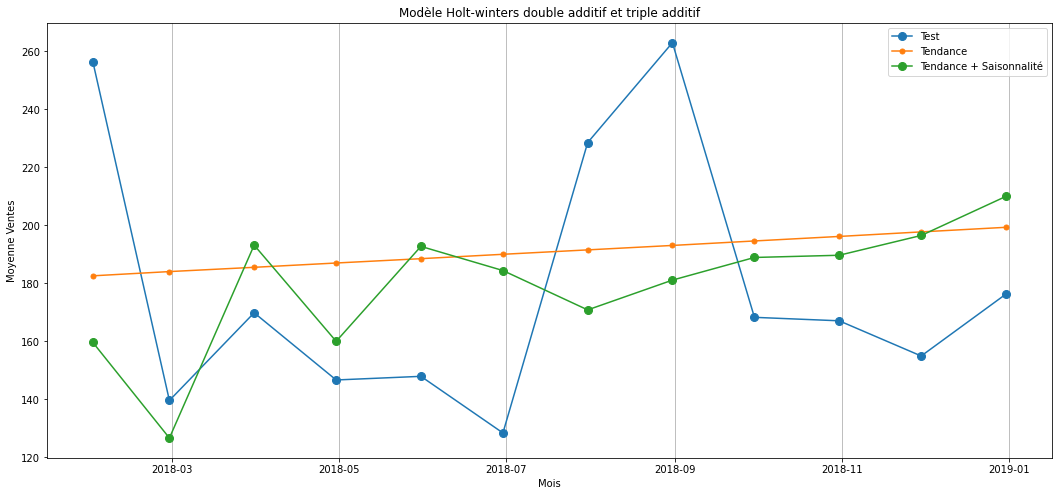

In [53]:

fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df_month_interpolated_test.Sales, marker = 'o', markersize = 8, label = 'Test')
ax.plot(predictions_holt_double, marker = 'o', markersize = 5, label = 'Tendance')
ax.plot(predictions_holt_triple, marker = 'o', markersize = 8, label = 'Tendance + Saisonnalité')
ax.grid(axis='x')
plt.xlabel('Mois')
plt.ylabel('Moyenne Ventes')
plt.title('Modèle Holt-winters double additif et triple additif')
ax.legend()
plt.show()

In [54]:
mse_model_double = mean_squared_error(df_month_interpolated_test.Sales,predictions_holt_double)
rsme_model_double = np.sqrt(mse_model_double)

mse_model_triple = mean_squared_error(df_month_interpolated_test.Sales,predictions_holt_triple)
rsme_model_triple = np.sqrt(mse_model_triple)

print(f"La racine de l'erreur quadratique moyenne du modèle Holt_winters double est de : {rsme_model_double} ")
print(f"La racine de l'erreur quadratique moyenne du modèle Holt_winters triple est de : {rsme_model_triple} ")

La racine de l'erreur quadratique moyenne du modèle Holt_winters double est de : 45.537377656514764 
La racine de l'erreur quadratique moyenne du modèle Holt_winters triple est de : 49.34207638554812 


### ARIMA

On utilise le modèle ARIMA au lieu du SARIMA étant donné que notre série n'admet pas de saisonnalité et stationnaire après une différenciation.

Le modèle ARIMA est caractérisé par trois variables **p,q,d**. $\\$
p est l'ordre du terme auto-régressif $\\$
q est l'odre du terme à moyenne mobile $\\$
d est le nombre de différences nécessaire pour rendre la série stationnaire.

Ces variables sont à déterminer afin de les donner au modèle ARIMA. $\\$
Nous avons vu précédemment grâce au test de Dickey-Fuller augmenté et KPSS qu'il faut une diférenciation pour rendre la série est stationnaire. $\\$
Donc, **d=1**. $\\$
Il nous reste à déterminer **p** et **q**.


Déterminons ces termes en utilisant le graphique d'autocorrélation (ACF) et le graphique d'autocorrélation partielle (PACF).

Le graphique d'autocorrélation partielle nous permet de trouver la valeur du processus à moyenne mobile.

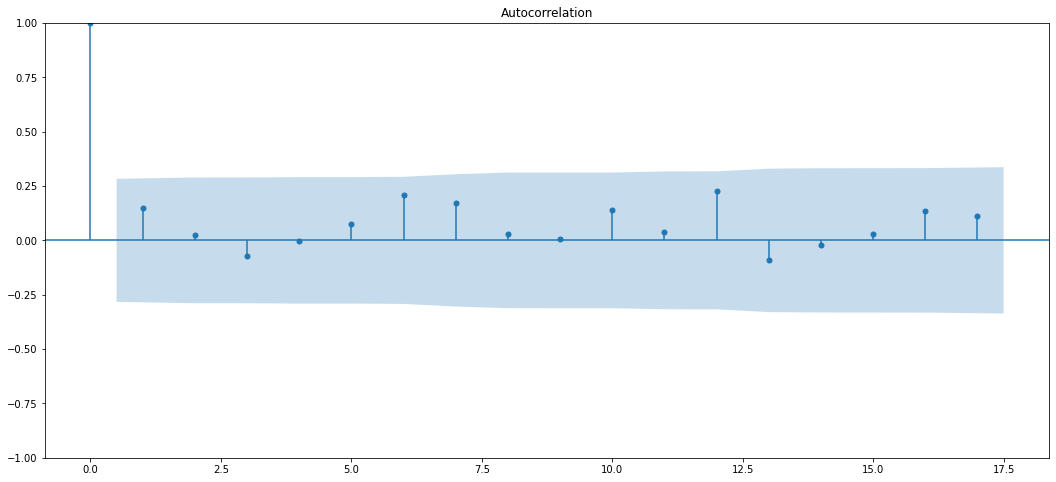

In [55]:
plot_acf(df_month_interpolated);

Le graphique d'autocorrélation partielle nous permet de trouver la valeur du processus à moyenne mobile.


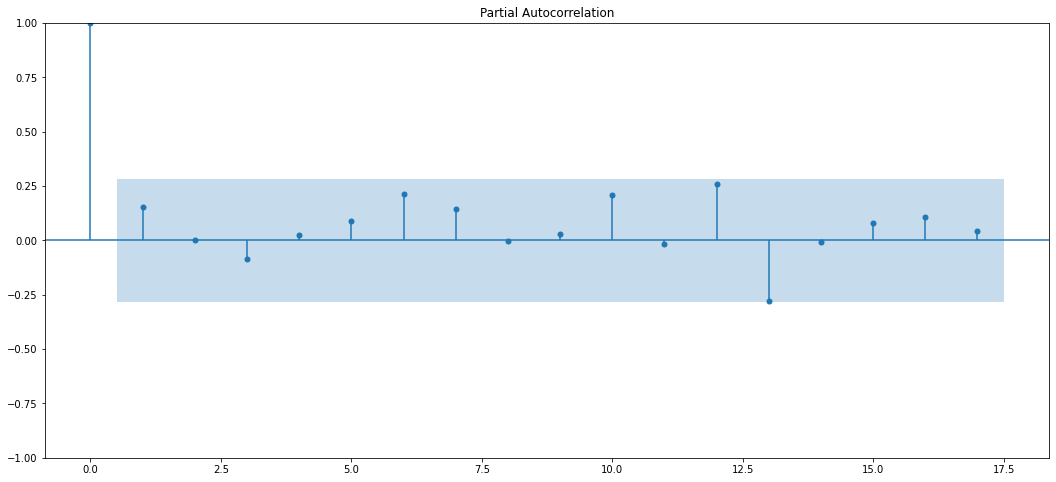

In [56]:
plot_pacf(df_month_interpolated);


In [57]:
p=10
q=0
d=1
model_arima = ARIMA(df_month_interpolated_train,order = (p,d,q),trend='n',seasonal_order=(1,1,1,12))
model_arima = model_arima.fit()
predictions_arima = model_arima.forecast(test_size)
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   36
Model:             ARIMA(10, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -103.639
Date:                             Sat, 22 Jan 2022   AIC                            233.277
Time:                                     21:25:14   BIC                            248.039
Sample:                                 01-31-2015   HQIC                           236.990
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0926      0.632     -1.728      0.084      -2.332       0.147
ar.L2         -0.6983      0.866     -0.806      0.420      -2.396       1.000
ar.L3         -0.7956      1.196     -0.665      0.506      -3.140       1.548
ar.L4         -1.2000      0.957     -1.254      0.210      -3.076       0.676
ar.L5         -0.8958      1.428     -0.627      0.531      -3.695       1.903
ar.L6         -0.3020      1.093     -0.276      0.782      -2.445       1.840
ar.L7         -0.3449      0.957     -0.360      0.719      -2.221       1.531
ar.L8         -0.6034      1.094     -0.551      0.581      -2.748       1.541
ar.L9         -0.5358      0.904     -0.593      0.553      -2.307       1.236
ar.L10         0.1370      0.725      0.189      0.850      -1.285       1.559
ar.S.L12      -0.4679      1.333     -0.351      0.726      -3.080       2.144
ma.S.L12      -0.7801      9.277     -0.084      0.933     -18.963      17.403
sigma2       177.9924   1536.704      0.116      0.908   -2833.893    3189.878
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.98   Prob(JB):                         0.79
Heteroskedasticity (H):               0.80   Skew:                             0.03
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

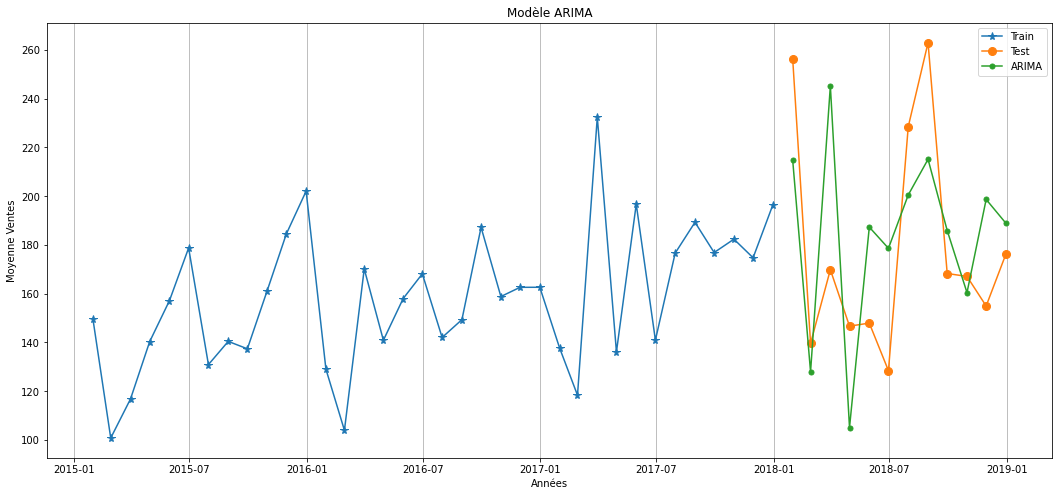

In [59]:

fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df_month_interpolated_train.Sales, marker ="*", markersize = 8 , label = 'Train')
ax.plot(df_month_interpolated_test.Sales, marker = 'o', markersize = 8, label = 'Test')
ax.plot(predictions_arima, marker = 'o', markersize = 5, label = 'ARIMA')
ax.grid(axis='x')
plt.xlabel('Années')
plt.ylabel('Moyenne Ventes')
plt.title('Modèle ARIMA')
ax.legend()
plt.show()

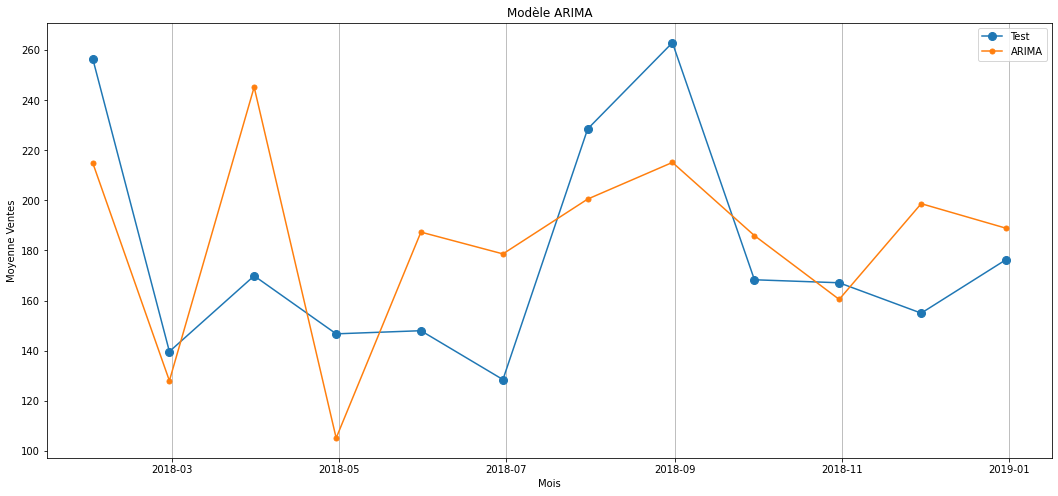

In [60]:

fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df_month_interpolated_test.Sales, marker = 'o', markersize = 8, label = 'Test')
ax.plot(predictions_arima, marker = 'o', markersize = 5, label = 'ARIMA')
ax.grid(axis='x')
plt.xlabel('Mois')
plt.ylabel('Moyenne Ventes')
plt.title('Modèle ARIMA')
ax.legend()
plt.show()

In [61]:
mse_model_arima = mean_squared_error(df_month_interpolated_test.Sales,predictions_arima)
rsme_model_arima = np.sqrt(mse_model_arima)

print(f"La racine de l'erreur quadratique moyenne du modèle ARIMA est de : {rsme_model_arima} ")

La racine de l'erreur quadratique moyenne du modèle ARIMA est de : 39.62351715788086 


### Réseau de neurones

#### Réseau de neurones RNN

#### Réseau de neurone TLSM

In [62]:
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import  Bidirectional


In [63]:
df_month_interpolated = df_month_interpolated.copy()
#Découpage App/Test 
test_size = df_month_interpolated.shape[0]//4

train_size = df_month_interpolated.shape[0]-test_size

df_month_interpolated_train = df_month_interpolated.iloc[:train_size]
df_month_interpolated_test = df_month_interpolated.iloc[train_size:]

In [64]:

# Normalisation des données entre 0 et 1
sc = MinMaxScaler(feature_range = (0, 1))
df_month_interpolated_train_normalise = pd.DataFrame(sc.fit_transform(df_month_interpolated_train))[0]
df_month_interpolated_test_normalise = pd.DataFrame(sc.fit_transform(df_month_interpolated_test))[0]




In [77]:

# Normalisation des données entre 0 et 1
sc = MinMaxScaler(feature_range = (0, 1))
df_month_interpolated_normalise = pd.DataFrame(sc.fit_transform(df_month_interpolated))[0]




In [65]:

#Construire de X_train et Y_train 
#nb_features :nombre de prédicteurs
X_train = []
Y_train = []
nb_features=3
n_train = df_month_interpolated_train_normalise.shape[0]
for i in range(nb_features,n_train ):
    X_train.append(df_month_interpolated_train_normalise[i-nb_features:i].to_numpy())
    Y_train.append(df_month_interpolated_train_normalise[i])
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
X_train.shape


(33, 1, 3)

In [ ]:

#Construire de X_train et Y_train 
#nb_features :nombre de prédicteurs
X_train = []
Y_train = []
X_test = []
Y_test = []
nb_features=3
n = df_month_interpolated_normalise.shape[0]
iter=0
for i in range(nb_features,n ):
    if(i < train_size):
        X_train.append(df_month_interpolated_normalise[i-nb_features:i].to_numpy())
        Y_train.append(df_month_interpolated_normalise[i])
    else:
        X_test.append(df_month_interpolated_normalise[i-nb_features:i].to_numpy())
        Y_test.append(df_month_interpolated_normalise[i])  
    i=i+1
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
print(X_train.shape)
print(X_test.shape)


In [66]:
#Construire de X_train et Y_train 
#nb_features :nombre de prédicteurs
X_test = []
Y_test = []
nb_features=3
for i in range(nb_features,test_size ):
    X_test.append(df_month_interpolated_test_normalise[i-nb_features:i].to_numpy())
    Y_test.append(df_month_interpolated_test_normalise[i])
X_test=np.array(X_test)
Y_test=np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
X_test.shape


(9, 1, 3)

In [67]:
regressor = Sequential()
# Le modèle séquentiel est une pile linéaire de couches.


2022-01-22 21:25:56.541690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-22 21:25:56.541716: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-22 21:25:56.541736: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cmi-isi-01): /proc/driver/nvidia/version does not exist
2022-01-22 21:25:56.542022: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [68]:

# units : correspond à la sortie de chaque couche
# on construit 5 couches LSTM avec 50
# return_sequences = True pour retourner les valeurs des couches cachées importante pour les couches suivantes
# regressor.add(Dropout(0.2)) utiliser qu'une partie des données train pour l'activation, permet d'éviter le surapprentissage
#regressor.add(LSTM(units = 50)) plus besoin de retourner les valeurs intermediaires car la dernière couche
# est une couche simple à une sortie qui donne la prédiction 


regressor.add(LSTM(units = 100, return_sequences = True, input_shape = ( 1,X_train.shape[2])))
regressor.add(Dropout(0.1))
regressor.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
regressor.add(Dropout(0.1))
regressor.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
regressor.add(Dropout(0.1))
regressor.add(Bidirectional(LSTM(units = 25)))
regressor.add(Dropout(0.1))
regressor.add(Dense(units = 1))


optimizer : Il peut s’agir d’un optimiseur défini par son appellation, par exemple rmsprop ou adagrad , ou d’une instance de la classe Optimizer.


In [69]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, Y_train, epochs = 200, batch_size = 32)


Epoch 1/200
2/2 [==============================] - 10s 15ms/step - loss: 0.2533
Epoch 2/200
2/2 [==============================] - 0s 6ms/step - loss: 0.2445
Epoch 3/200
2/2 [==============================] - 0s 6ms/step - loss: 0.2355
Epoch 4/200
2/2 [==============================] - 0s 7ms/step - loss: 0.2265
Epoch 5/200
2/2 [==============================] - 0s 7ms/step - loss: 0.2171
Epoch 6/200
2/2 [==============================] - 0s 7ms/step - loss: 0.2052
Epoch 7/200
2/2 [==============================] - 0s 7ms/step - loss: 0.1937
Epoch 8/200
2/2 [==============================] - 0s 7ms/step - loss: 0.1791
Epoch 9/200
2/2 [==============================] - 0s 7ms/step - loss: 0.1650
Epoch 10/200
2/2 [==============================] - 0s 7ms/step - loss: 0.1489
Epoch 11/200
2/2 [==============================] - 0s 8ms/step - loss: 0.1309
Epoch 12/200
2/2 [==============================] - 0s 7ms/step - loss: 0.1078
Epoch 13/200
2/2 [==============================] - 0s 7ms/

In [70]:

predictions_lstm = regressor.predict(X_test)
predictions_lstm = sc.inverse_transform(predictions_lstm)


In [71]:
Y_test=Y_test.reshape(-1, 1)
Y_test_non_normalise=sc.inverse_transform(Y_test)


In [72]:
df_month_interpolated_test_pred=df_month_interpolated_test.slice_shift(nb_features)
df_month_interpolated_test_pred['Sales']=Y_test_non_normalise
df_month_interpolated_test_pred['Pred']=predictions_lstm


In [73]:
df_month_interpolated_train=df_month_interpolated_train.slice_shift(nb_features)
df_month_interpolated_train

,Sales
time,
2015-04-30,149.826578
2015-05-31,100.810436
2015-06-30,116.852344
2015-07-31,140.351844
2015-08-31,157.184608
2015-09-30,178.779277
2015-10-31,130.929942
2015-11-30,140.453257
2015-12-31,137.412135


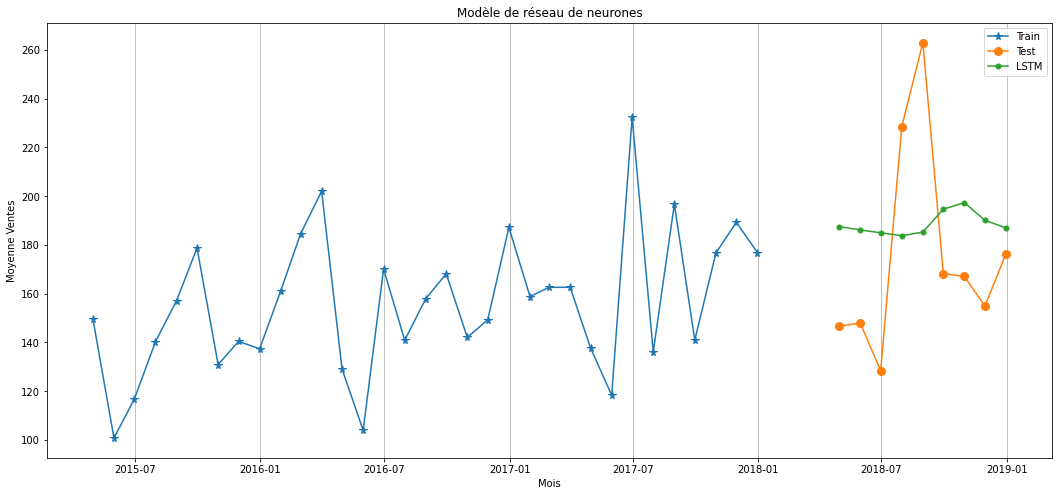

In [74]:

fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df_month_interpolated_train.Sales, marker ="*", markersize = 8 , label = 'Train' )
ax.plot(df_month_interpolated_test_pred.Sales, marker = 'o', markersize = 8, label = 'Test')
ax.plot(df_month_interpolated_test_pred.Pred, marker = 'o', markersize = 5, label = 'LSTM')
ax.grid(axis='x')
plt.xlabel('Mois')
plt.ylabel('Moyenne Ventes')
plt.title('Modèle de réseau de neurones')
ax.legend()
plt.show()

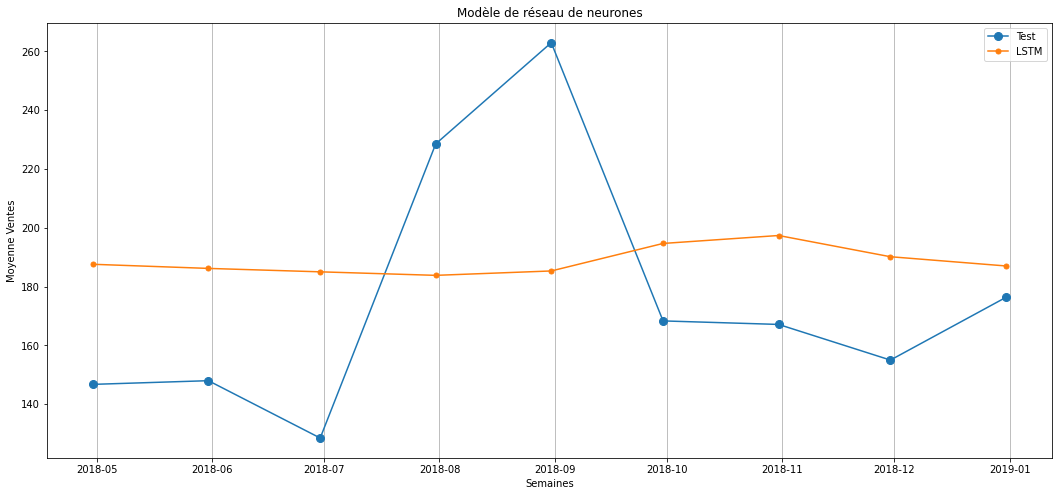

In [75]:

fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df_month_interpolated_test_pred.Sales, marker = 'o', markersize = 8, label = 'Test')
ax.plot(df_month_interpolated_test_pred.Pred, marker = 'o', markersize = 5, label = 'LSTM')
ax.grid(axis='x')
plt.xlabel('Semaines')
plt.ylabel('Moyenne Ventes')
plt.title('Modèle de réseau de neurones')
ax.legend()
plt.show()

In [76]:
mse_model_lstm = mean_squared_error(df_month_interpolated_test_pred.Sales,df_month_interpolated_test_pred.Pred)
rsme_model_lstm = np.sqrt(mse_model_lstm)


print(f"La racine de l'erreur quadratique moyenne du modèle Holt_winters double est de : {rsme_model_lstm} ")


La racine de l'erreur quadratique moyenne du modèle Holt_winters double est de : 43.876455379381774 


## Conlusion 

Meilleur modèle réseaux de neurones LSTM.